In [7]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import pickle
import threading
from lesson_functions import *
from windows import *
from collections import deque
from IPython.core.debugger import Tracer

with open('svm-yuv-16x2x11.p', 'rb') as f:
    data = pickle.load(f)
    svc = data['svm']
    X_scaler = data['scaler']
    params = data['params']
    
print('Data Loaded')
print('SVC:', svc)
print('Params', params)

Data Loaded
SVC: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Params {'hist_feat': True, 'spatial_size': (32, 32), 'spatial_feat': True, 'orient': 11, 'hog_feat': True, 'pix_per_cell': 16, 'hist_bins': 32, 'hog_channel': 'ALL', 'C': 1, 'color_space': 'YUV', 'kernel': 'linear', 'cell_per_block': 2}


C:\Users\fahad\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Cars found: 1


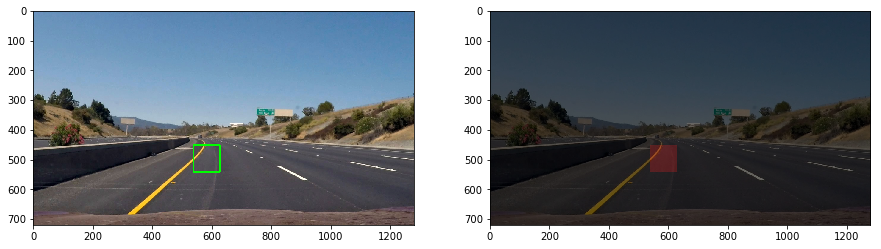

In [27]:
def colorspace2rgb(img_cs):
    return cv2.cvtColor(img_cs, eval('cv2.COLOR_' + params['color_space'] + '2RGB'))

def rgb2colorspace(img_rgb):
    return cv2.cvtColor(img_rgb, eval('cv2.COLOR_RGB2' + params['color_space']))

class SingleFrameCarFinder():
    def __init__(self, svc, X_scaler):
        self.svc = svc
        self.X_scaler = X_scaler
        self.windows = None
        self.img_cs = None
        self.window_features = []
        self.car_windows = []
        self.heatmap = None
    
    def init_for_frame(self, img_cs):
        self.img_cs = img_cs
        self.img_rgb = colorspace2rgb(self.img_cs)
        self.heatmap = np.zeros(img_cs.shape[:2], np.float)
        self.window_features = []
        self.car_windows = []
        
    def find_features(self, img_cs):
        if self.windows is None:
            self.windows = get_all_windows(img_cs)
        
        for window in self.windows:
            window_img = img_cs[window[0][1]:window[1][1], window[0][0]:window[1][0]]
            window_img_64 = cv2.resize(window_img, (64,64))

            w_features = single_img_features(window_img_64, 
                        spatial_size=params['spatial_size'],
                        hist_bins=params['hist_bins'], 
                        orient=params['orient'], 
                        pix_per_cell=params['pix_per_cell'], 
                        cell_per_block=params['cell_per_block'],
                        hog_channel=params['hog_channel'],
                        spatial_feat=params['spatial_feat'],
                        hist_feat=params['hist_feat'], 
                        hog_feat=params['hog_feat'],
                        vis=False)
        
            self.window_features.append(w_features)
        
        self.window_features = X_scaler.transform(self.window_features)
            
    def draw_windows(self, img = None, windows = None, color=(0, 255, 0)):
        #Tracer()() #this one triggers the debugger
        
        if img is None:
            img = np.copy(self.img_rgb)
            
        if windows is None:
            windows = self.car_windows
            
        for window in windows:
            cv2.rectangle(img, window[0], window[1], color, 4)
        return img

    def add_heat(self, windows):
        for window in windows:
            self.heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1

    def get_heat_img(self, heatmap = None):
        if heatmap is None:
            heatmap = self.heatmap
            
        hot_colors = [(0,0,0), (90,0,0), (212,0,0), (255, 63, 0), (255,103,0), (255,225,0), (255,225,0), (255,225,0)]

        heatmap_clipped = np.clip(heatmap, 0, 255)
        
        max_heat = np.max(heatmap_clipped)
        cap = len(hot_colors) - 1
        
        if max_heat >= cap:
            # only change those colors which are > 0 
            mask = heatmap_clipped > 0
            heatmap_clipped[mask] = (heatmap_clipped[mask] / max_heat * cap + 1)

        heat_img = np.zeros(shape=self.img_rgb.shape).astype(np.uint8)

        for index in range(0, cap):
            mask = (heatmap_clipped > index) & (heatmap_clipped <= index + 1)
            locations = np.where(mask)

            if locations[0].shape[0] > 0:
                heat_img[locations[0], locations[1]] = hot_colors[index + 1]

        return cv2.addWeighted(self.img_rgb, 0.4, heat_img, 0.6, 0)
        
    def predict_cars(self, img_cs):
        self.init_for_frame(img_cs)
        
        self.find_features(img_cs)
        self.car_windows = []
        
        for index, window in enumerate(self.window_features):
             if self.svc.predict([window]):
                self.car_windows.append(self.windows[index])
        
        self.add_heat(self.car_windows)
        return self.car_windows
        
img_cs = load_image('./project_video-frames/0000.jpg', params['color_space'])
cf = SingleFrameCarFinder(svc, X_scaler)
car_windows = cf.predict_cars(img_cs)

print('Cars found: {}'.format(len(car_windows)))

cars_found = cf.draw_windows(windows = car_windows)
heat_img = cf.get_heat_img()

f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,10))
ax1.imshow(cars_found)
ax2.imshow(heat_img)

plt.show()

3
4
5


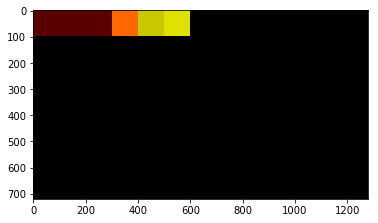

In [60]:
import numpy as np
from collections import deque

heatmaps = deque(maxlen = 2)

hot_colors = [(0,0,0), (90,0,0), (212,0,0), (255, 63, 0), (255,103,0), (200,200,0), (225,225,0), (255,225,0)]

heatmap = np.zeros(shape=(720,1280))
for i in range(6):
    heatmap[0:100, i * 100:i * 100 + 100] = 1
heatmaps.append(heatmap)

heatmap2 = np.zeros(shape=(720,1280))
for i in range(3,6):
    print(i)
    heatmap2[0:100, i * 100:i * 100 + 100] = i
heatmaps.append(heatmap2)
 
heatmap = np.sum(heatmaps, axis=0)
# heatmap = heatmap2

heatmap_clipped = np.clip(heatmap, 0, 255)

max_heat = np.max(heatmap_clipped)
cap = len(hot_colors) - 1

if max_heat >= cap:
    print(max_heat, 'has reached')
    # only change those colors which are > 0 
    mask = heatmap_clipped > 0
    heatmap_clipped[mask] = (heatmap_clipped[mask] / max_heat * cap + 1)

heat_img = np.zeros(shape=(720,1280,3)).astype(np.uint8)

for index in range(0, cap):
    mask = (heatmap_clipped > index) & (heatmap_clipped <= index + 1)
    locations = np.where(mask)

    if locations[0].shape[0] > 0:
        heat_img[locations[0], locations[1]] = hot_colors[index + 1]

plt.imshow(heat_img)
plt.show()

## Multiple Frame Car Finder

In [42]:
def debug(str, *args):
    #print(str, args)
    pass

def get_w_h(box):
    width = box[1][0] - box[0][0]
    height = box[1][1] - box[0][1]
    return width, height

def get_center(box):
    width, height = get_w_h(box)
    return np.int_([box[0][0] + width // 2, box[0][1] + height // 2])

RIGHT_THRESHOLD = 10
LEFT_THRESHOLD = 20
MAX_MISSFRAMES = 10

class Vehicle():
    def __init__(self, car_no):
        self.bounding_box = None
        self.last_bounding_box = None
        self.speed = 0.0
        self.center = None
        self.car_no = car_no
        self.alpha = 0.5
        self.center_alpha = 0.7
        self.frame_count = 0
        self.miss_frames = 0
        self.accounted_miss_frames = 0

    def is_box_enclosing(self, box):
        return (self.center[0] >= box[0][0]) and (self.center[0] <= box[1][0]) \
                and (self.center[1] >= box[0][1]) and (self.center[1] <= box[1][1])
    
    def might_go_out(self):
        # in case the car is towards the bottom of the screen and is not a new car
        return self.frame_count > 3 and self.center[1] >= 650 
    
    def is_within_bounds(self, center):
        # get the sum of square difference between 2 centers and see if it is 
        # within bounds then yes, otherwise no
        return np.sqrt(np.sum((self.center - center) ** 2)) <= self.bound_pixels
        
    def update_box(self, box):
        self.miss_frames = 0
        self.accounted_miss_frames = 0
        self.frame_count += 1

        width, height = get_w_h(box)
        
        if self.center is None:
            self.bounding_box = box
            self.center = get_center(box)
        else:
            self.last_bounding_box = self.bounding_box

            # increase / decrease slowly
            old_width, old_height = get_w_h(self.last_bounding_box)
            
            new_width = old_width * (1 - self.alpha) + width * self.alpha
            new_height = old_height * (1 - self.alpha) + height * self.alpha

            center = get_center(box)
            
            last_center = self.center
            self.center = last_center * (1 - self.center_alpha) + center * self.center_alpha
            
            self.bounding_box = (int(self.center[0] - new_width // 2), int(center[1] - new_height // 2)), \
                                (int(center[0] + new_width // 2), int(center[1] + new_height // 2))
        
            delta = self.center - last_center
            self.speed += delta

    def nudge_as_per_speed(self):
#         delta_per_frame = self.speed / self.frame_count
#         estimated_movement = (self.miss_frames - self.accounted_miss_frames) / delta_per_frame
#         self.accounted_miss_frames = self.miss_frames
#         self.center[0] += estimated_movement[0]
#         self.center[1] += estimated_movement[1]
        pass

    def get_all_fit_boxes(self, img):
        # will return all box sizes with our current center, used for rechecking to make sure the car is no
        # longer in frame
        all_box_sizes = get_all_box_sizes(img)

        detection_boxes = []
        for width, height in all_box_sizes:
            bounding_box = self.make_box_from_center(width, height)
            detection_boxes.append(bounding_box)

        return detection_boxes

    def make_box_from_center(self, width, height):
        bounding_box = (max(int(self.center[0] - width // 2),0), \
                        max(int(self.center[1] - height // 2), 0), \
                        min(int(self.center[0] + width // 2), 1280), \
                        min(int(self.center[1] + height // 2), 720))
        return bounding_box
            
class VehicleIdentifier():
    def __init__(self):
        self.min_frames = 20
        self.frames_to_avg = 10
        self.heatmaps = deque(maxlen = self.frames_to_avg)
        self.cars = []
        self.cars_gone_off = []
        self.last_frame_no = 0  # helps in debugging, pickle object and then start again from same frame
        self.car_finder = SingleFrameCarFinder(svc, X_scaler)
        self.car_windows = None
        
    def get_bounding_box(self, labels, car_no):
        mask = labels[0] == car_no

        nonzero = (mask).nonzero()

        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        return bbox

    def get_car_for_bbox(self, bbox):
        car = None
        center = get_center(bbox)
        
        for c in self.cars:
            #if c.is_within_bounds(center):
            if (c.center[0] >= bbox[0][0]) and (c.center[0] <= bbox[1][0]) and (c.center[1] >= bbox[0][1]) and (c.center[1] <= bbox[1][1]):
                car = c
                break
                
        return car
    
    def draw_labels_img(self, labels):
        colors = [(255,0,0), (0,255,0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
                  (255, 0, 255), (255, 150, 0), (255, 0, 150), (150, 75, 0), (150, 0, 75)]

        labels_img = np.zeros_like(self.img_rgb)

        # add more colors to the array in case there are more labels than number of defined colors
        if labels[1] == len(colors):
            extra = labels[1] - len(colors)
            colors.extend([(255,0,0)] * extra)

        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            mask = labels[0] == car_number
            labels_img[mask] = colors[car_number - 1]

        return labels_img

    def draw_cars(self, output_img):
        for car in self.cars:
            cv2.rectangle(output_img, car.bounding_box[0], car.bounding_box[1], (0,255,0), 6)

    def make_bounding_box(self, boxes):
        if len(boxes) < 2:
            nboxes = np.array([boxes])
        else:
            nboxes = np.array(boxes)
        # change the array shape so that it becomes
        # x = [[1,2,3,4],[4,5,6,7]]
        nboxes = nboxes.reshape(nboxes.shape[0], -1)
        x1 = np.min(nboxes[:,0])
        y1 = np.min(nboxes[:,1])
        x2 = np.max(nboxes[:,2])
        y2 = np.max(nboxes[:,3])

        box = (x1,y1),(x2,y2)
        return box

    def figure_out_cars(self, boxes):
        summed_up = np.sum(self.heatmaps, axis=0)
        #print(np.max(summed_up))

        #heatmap_threshold(summed_up[:,600:], RIGHT_THRESHOLD)
        #heatmap_threshold(summed_up[:,:600], LEFT_THRESHOLD)
        heatmap_threshold(summed_up, RIGHT_THRESHOLD)

        self.labels = label(summed_up)
        
        cars_seen = [False] * len(self.cars)
        
        for car_no in range(1, self.labels[1]+1):
            car_box = self.get_bounding_box(labels, car_no)
            car = self.get_car_for_bbox(car_box)
            
            if car is None:
                print('We have never seen this car # before. box:', car_box)
                car = Vehicle(car_no)
                
                self.cars.append(car)
                cars_seen.append(True)  # add a new car to the cars_seen array
            else:
                cars_seen[car.car_no - 1] = True
            
            car.update_box(car_box)
            
        # is there a car that we did not see this time? if yes, maybe
        # it could have been overlapping
        for i in range(len(cars_seen)):
            if cars_seen[i] == False:
                car = self.cars[i]
                debug('did not see car #', car.car_no, 'speed:', car.speed)
                # make sure bounding box has not been overlapped with some other's
                car_boxes = []
                for box in boxes:
                    if car.is_box_enclosing(box):
                        car_boxes.append(box)

                if len(car_boxes) > 0:
                    bbox = self.make_bounding_box(car_boxes)
                    car.update_box(bbox)
                    cars_seen[i] = True
                else:
                    car.miss_frames += 1

                    # oh really! the car went out. lets resample around the box we have for the car and then see if we
                    # can detect a car there
                    img_cs = cv2.cvtColor(self.img, color_space_code)
                    img_tl = np.copy(self.img)

                    boxes = car.get_all_fit_boxes(img_cs)
                    for box in boxes:
                        cv2.rectangle(img_tl, box[0], box[1], (255, 0, 0), 4)

                        if has_car(img_cs, box):
                            car_boxes.append(box)

                    output_img[0:180,0:320] = cv2.resize(img_tl, (320, 180))
                    if len(car_boxes) > 0:
                        # okay we found some car using some of our box sizes, so lets make a new bounding box
                        # using the average of all boxes
                        widths = []
                        heights = []

                        for box in car_boxes:
                            w, h = get_w_h(box)
                            widths.append(w)
                            heights.append(h)

                        avg_w = np.average(np.array(widths))
                        avg_h = np.average(np.array(heights))

                        box = car.make_box_from_center(avg_w, avg_h)
                        car.update_box(box)
                        cars_seen[i] = True
                    else:
                        # in case we have not estimated the car to move out of our vision
                        # estimate where it should be and nudge it a little
                        if not car.might_go_out() and car.miss_frames < MAX_MISSFRAMES:
                            #car.nudge_as_per_speed()
                            cars_seen[i] = True

                    #if not car.might_go_out() and car.miss_frames < MAX_MISSFRAMES:
                        
                        #cars_seen[i] = True

        # remove all cars that were not seen
        existing_cars = self.cars
        self.cars = []
        for i in range(len(cars_seen)):
            if cars_seen[i]:
                self.cars.append(existing_cars[i])
            else:
                self.cars_gone_off.append(existing_cars[i])
        
    def overlay_images(self):
        output_img = np.copy(self.img_rgb)

        frame_heat_img = self.car_finder.get_heat_img()

        img_tl = np.copy(self.img_rgb)
        self.car_finder.draw_windows(img = img_tl, color = (0, 255, 0))
        
        # draw this frame's heatmap on the top center of the image
        output_img[0:180,320:640] = cv2.resize(frame_heat_img, (320, 180))
        output_img[0:180,0:320] = cv2.resize(img_tl, (320, 180))

        # wait till we have enough heat maps to average out
        if len(self.heatmaps) <= self.frames_to_avg:
            cv2.putText(output_img, "Waiting for frames", (650, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        else:
            self.draw_cars(output_img)

            labels_img = self.draw_labels_img(self.labels)
            heat_img = self.car_finder.get_heat_img(summed_up)

            output_img[0:180,640:960] = cv2.resize(heat_img, (320, 180))
            output_img[0:180,960:1280] = cv2.resize(labels_img, (320,180))

            cv2.putText(output_img, "Cars: {}".format(len(self.cars)), (970, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        
        return output_img

    def process_frame(self, img_rgb):
        debug('Processing image, len(car)', len(self.cars))
        
        self.img_rgb = img_rgb
        self.img_cs = rgb2colorspace(img_rgb)
        
        self.car_windows = self.car_finder.predict_cars(self.img_cs)

        self.heatmaps.append(self.car_finder.heatmap)
        
        if len(self.heatmaps) >= self.frames_to_avg:
            self.figure_out_cars(self.car_windows)

        return self.overlay_images()

car = Vehicle(1)
car.center = (500,500)
print(car.make_box_from_center(100,100))

# filename = './project_video-frames/0000.jpg'
# img_rgb = load_image(filename, 'RGB')

# vi = VehicleIdentifier()
# overlay_img = vi.process_frame(img_rgb)

# plt.imshow(overlay_img)
# plt.show()

(450, 450, 550, 550)


In [37]:
import os

if os.path.exists('identifier.p'):
    with open('identifier.p', 'rb') as f:
        try:
            identifier = pickle.load(f)
            print('Old identifier loaded with frame:', identifier.last_frame_no)
        except EOFError as e:
            print(e)
            print('Loading a new identifier')
            identifier = VehicleIdentifier()
            identifier.threshold = 20
else:
    identifier = VehicleIdentifier()
    print('New identifier created')

for identifier.last_frame_no in range(identifier.last_frame_no + 1, 800):
    filename = './project_video-frames/{:04d}.jpg'.format(identifier.last_frame_no)
    
    # read RGB since thats what video will give us and then our function
    # internally converts it to LAB
    img = load_image(filename, 'RGB')

    t1 = time.time()
    output_img = identifier.process_image(img)
    t2 = time.time()
    print('Frame {}, time taken {:.3f} secs'.format(identifier.last_frame_no, t2 - t1))
    
    output_img = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('./frame-cars/{:04d}.jpg'.format(identifier.last_frame_no), output_img)

    with open('identifier.p', 'wb') as f:
        pickle.dump(identifier, f)
    # print('Frame:', frame_no)
    # plt.imshow(output_img)
    # plt.show(block=False)

New identifier created
